# Load packages and dependencies

In [4]:
import os
import json
import math
from google.colab import drive
import wave
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras as keras

import librosa
import IPython.display as display

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Mount the google drive
adisamproject@gmail.com

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# One audio file Inspection

## Load an example audio file

In [6]:
DATASET_PATH = "/content/drive/My Drive/dataset/english/backward"
example_audio_path = os.path.join(DATASET_PATH, '0a2b400e_nohash_0.wav')
audio_signal, sample_rate = librosa.load(example_audio_path)

## Information about audio file

In [7]:
obj = wave.open('/content/drive/My Drive/dataset/english/backward/0a2b400e_nohash_0.wav', 'rb')
print('Number of channels:', obj.getnchannels())
print('Sample width:', obj.getsampwidth())
print('Frame rate:', obj.getframerate())
print('Number of frames:', obj.getnframes())
print('Parameters:', obj.getparams())

Number of channels: 1
Sample width: 2
Frame rate: 16000
Number of frames: 16000
Parameters: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=16000, comptype='NONE', compname='not compressed')


## Visualize the audio waveform

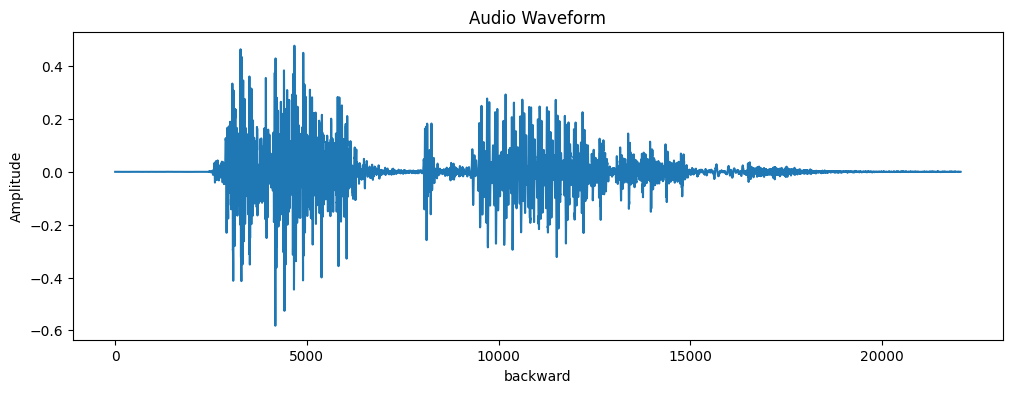

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(audio_signal)
plt.title('Audio Waveform')
plt.xlabel('backward')
plt.ylabel('Amplitude')
plt.show()


## Audio Signal Characteristics


In [9]:
duration = librosa.get_duration(y=audio_signal, sr=sample_rate)
print(f"Duration: {duration} seconds")
print(f"Sample Rate: {sample_rate} Hz")

Duration: 1.0 seconds
Sample Rate: 22050 Hz


## Frequency Analysis - Plot Spectrogram


<ipython-input-10-a4313ac71b65>:2: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  spectrogram = librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(audio_signal), ref=np.max),


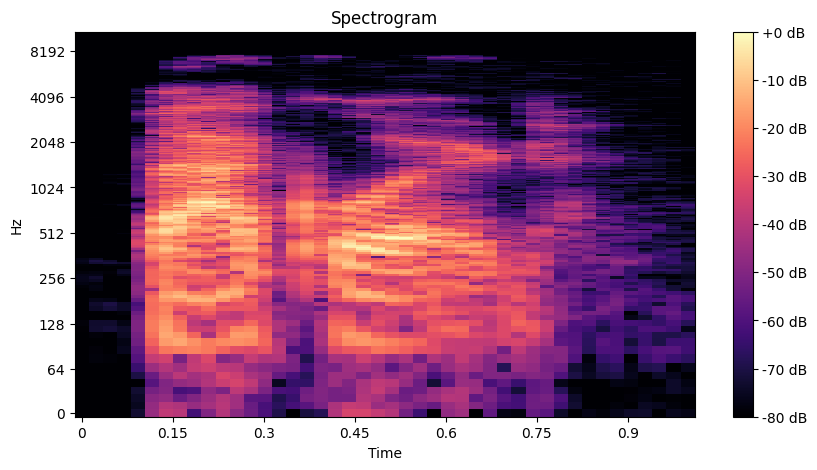

In [10]:
plt.figure(figsize=(10, 5))
spectrogram = librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(audio_signal), ref=np.max),
                                       y_axis='log', x_axis='time', sr=sample_rate)
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()


## Amplitude Distribution


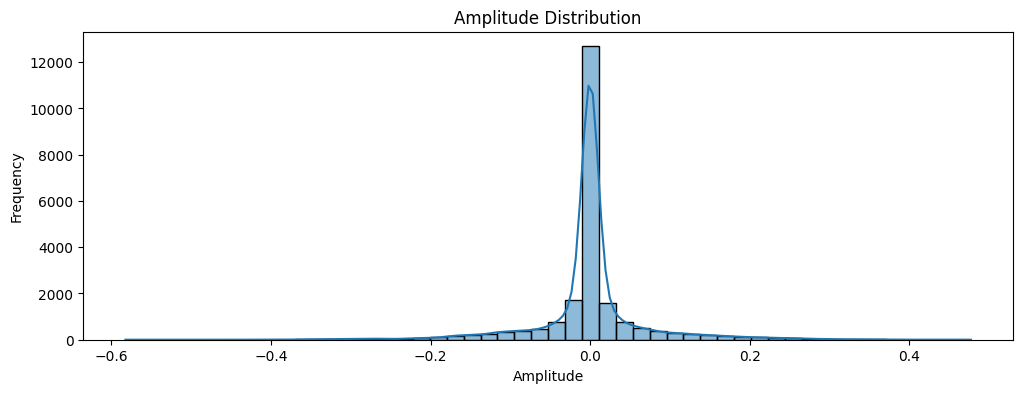

In [11]:
plt.figure(figsize=(12, 4))
sns.histplot(audio_signal, bins=50, kde=True)
plt.title('Amplitude Distribution')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.show()


## Data Statistics


In [12]:
audio_stats = pd.DataFrame(audio_signal, columns=['Amplitude'])
print(audio_stats.describe())


          Amplitude
count  22050.000000
mean       0.000168
std        0.070218
min       -0.582512
25%       -0.006600
50%        0.000004
75%        0.006194
max        0.477317


# Load the raw audio data
Data contains 6 classes of the words for the project hence 6 subfolders

In [13]:
DATASET_PATH = "/content/drive/My Drive/dataset/english"
JSON_PATH = "/content/drive/My Drive/Colab Notebooks/english/data.json"
data_dir = pathlib.Path(DATASET_PATH)

# Inspect the whole audio data

## Set some audio parameters

In [14]:
SAMPLE_RATE = 16000
AUDIO_DURATION = 2  # measured in seconds
SAMPLES_PER_AUDIO = SAMPLE_RATE * AUDIO_DURATION

## Explore available commands in the dataset

In [15]:

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['forward' 'no' 'left' 'stop' 'backward' 'right']


# Preprocess the data

In [16]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_AUDIO / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all sub-folders
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing the sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print(f"\nProcessing: {semantic_label}")

            # process all audio files in genre sub-dir
            for f in filenames:

                # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for the current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(y=signal[start:finish],
                                                sr=sample_rate,
                                                n_mfcc=num_mfcc,
                                                n_fft=n_fft,
                                                hop_length=hop_length)

                    mfcc = mfcc.T

                    # store only mfcc feature with the expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print(f"{file_path}, segment:{d+1}")

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

    # return the data dictionary
    return data


## Save the mfcc data

In [17]:
data = save_mfcc(DATASET_PATH, JSON_PATH, num_segments=6)


Processing: forward
/content/drive/My Drive/dataset/english/forward/9a76f8c3_nohash_3.wav, segment:1
/content/drive/My Drive/dataset/english/forward/9a76f8c3_nohash_3.wav, segment:2
/content/drive/My Drive/dataset/english/forward/9a76f8c3_nohash_3.wav, segment:3


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


/content/drive/My Drive/dataset/english/forward/3108acca_nohash_1.wav, segment:1
/content/drive/My Drive/dataset/english/forward/3108acca_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/forward/3108acca_nohash_1.wav, segment:3
/content/drive/My Drive/dataset/english/forward/211b928a_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/forward/211b928a_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/forward/211b928a_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/forward/85851131_nohash_1.wav, segment:1
/content/drive/My Drive/dataset/english/forward/85851131_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/forward/85851131_nohash_1.wav, segment:3
/content/drive/My Drive/dataset/english/forward/40738a2d_nohash_3.wav, segment:1
/content/drive/My Drive/dataset/english/forward/40738a2d_nohash_3.wav, segment:2
/content/drive/My Drive/dataset/english/forward/40738a2d_nohash_3.wav, segment:3
/content/drive/My Drive/data

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1622
  warnings.warn(


/content/drive/My Drive/dataset/english/forward/61ab8fbc_nohash_2.wav, segment:1
/content/drive/My Drive/dataset/english/forward/61ab8fbc_nohash_2.wav, segment:2
/content/drive/My Drive/dataset/english/forward/61ab8fbc_nohash_2.wav, segment:3
/content/drive/My Drive/dataset/english/forward/79903546_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/forward/79903546_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/forward/24cab2cb_nohash_1.wav, segment:1
/content/drive/My Drive/dataset/english/forward/24cab2cb_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/forward/30060aba_nohash_3.wav, segment:1
/content/drive/My Drive/dataset/english/forward/30060aba_nohash_3.wav, segment:2


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=939
  warnings.warn(


/content/drive/My Drive/dataset/english/forward/30060aba_nohash_3.wav, segment:3
/content/drive/My Drive/dataset/english/forward/8fe67225_nohash_4.wav, segment:1
/content/drive/My Drive/dataset/english/forward/8fe67225_nohash_4.wav, segment:2
/content/drive/My Drive/dataset/english/forward/8fe67225_nohash_4.wav, segment:3
/content/drive/My Drive/dataset/english/forward/0cb74144_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/forward/0cb74144_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/forward/0cb74144_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/forward/067f61e2_nohash_1.wav, segment:1
/content/drive/My Drive/dataset/english/forward/067f61e2_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/forward/067f61e2_nohash_1.wav, segment:3
/content/drive/My Drive/dataset/english/forward/a77fbcfd_nohash_2.wav, segment:1
/content/drive/My Drive/dataset/english/forward/a77fbcfd_nohash_2.wav, segment:2
/content/drive/My Drive/data

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1222
  warnings.warn(


/content/drive/My Drive/dataset/english/forward/616420be_nohash_1.wav, segment:1
/content/drive/My Drive/dataset/english/forward/616420be_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/forward/616420be_nohash_1.wav, segment:3
/content/drive/My Drive/dataset/english/forward/322d17d3_nohash_3.wav, segment:1
/content/drive/My Drive/dataset/english/forward/322d17d3_nohash_3.wav, segment:2
/content/drive/My Drive/dataset/english/forward/322d17d3_nohash_3.wav, segment:3
/content/drive/My Drive/dataset/english/forward/3cc595de_nohash_1.wav, segment:1
/content/drive/My Drive/dataset/english/forward/3cc595de_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/forward/3cc595de_nohash_1.wav, segment:3
/content/drive/My Drive/dataset/english/forward/a55105d0_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/forward/a55105d0_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/forward/a55105d0_nohash_0.wav, segment:3
/content/drive/My Drive/data

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=256
  warnings.warn(


/content/drive/My Drive/dataset/english/forward/1c84a139_nohash_1.wav, segment:3
/content/drive/My Drive/dataset/english/forward/1a994c9f_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/forward/1a994c9f_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/forward/1a994c9f_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/forward/23da904f_nohash_4.wav, segment:1
/content/drive/My Drive/dataset/english/forward/23da904f_nohash_4.wav, segment:2
/content/drive/My Drive/dataset/english/forward/23da904f_nohash_4.wav, segment:3
/content/drive/My Drive/dataset/english/forward/a6f2fd71_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/forward/a6f2fd71_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/forward/a6f2fd71_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/forward/8e523821_nohash_3.wav, segment:1
/content/drive/My Drive/dataset/english/forward/8e523821_nohash_3.wav, segment:2
/content/drive/My Drive/data

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1466
  warnings.warn(


/content/drive/My Drive/dataset/english/forward/90e72357_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/forward/31f01a8d_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/forward/31f01a8d_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/forward/31f01a8d_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/forward/0ea9c8ce_nohash_3.wav, segment:1
/content/drive/My Drive/dataset/english/forward/0ea9c8ce_nohash_3.wav, segment:2
/content/drive/My Drive/dataset/english/forward/0ea9c8ce_nohash_3.wav, segment:3
/content/drive/My Drive/dataset/english/forward/9331d34b_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/forward/9331d34b_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/forward/113b3fbc_nohash_2.wav, segment:1
/content/drive/My Drive/dataset/english/forward/113b3fbc_nohash_2.wav, segment:2
/content/drive/My Drive/dataset/english/forward/113b3fbc_nohash_2.wav, segment:3
/content/drive/My Drive/data

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1281
  warnings.warn(


/content/drive/My Drive/dataset/english/forward/2e75d37a_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/forward/91b03183_nohash_1.wav, segment:1
/content/drive/My Drive/dataset/english/forward/91b03183_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/forward/91b03183_nohash_1.wav, segment:3
/content/drive/My Drive/dataset/english/forward/0f7266cf_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/forward/0f7266cf_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/forward/0f7266cf_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/forward/89947bd7_nohash_4.wav, segment:1
/content/drive/My Drive/dataset/english/forward/89947bd7_nohash_4.wav, segment:2
/content/drive/My Drive/dataset/english/forward/89947bd7_nohash_4.wav, segment:3
/content/drive/My Drive/dataset/english/forward/08ab231c_nohash_2.wav, segment:1
/content/drive/My Drive/dataset/english/forward/08ab231c_nohash_2.wav, segment:2
/content/drive/My Drive/data

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1354
  warnings.warn(


/content/drive/My Drive/dataset/english/forward/435695e3_nohash_2.wav, segment:1
/content/drive/My Drive/dataset/english/forward/435695e3_nohash_2.wav, segment:2
/content/drive/My Drive/dataset/english/forward/435695e3_nohash_2.wav, segment:3
/content/drive/My Drive/dataset/english/forward/616420be_nohash_2.wav, segment:1
/content/drive/My Drive/dataset/english/forward/616420be_nohash_2.wav, segment:2
/content/drive/My Drive/dataset/english/forward/616420be_nohash_2.wav, segment:3
/content/drive/My Drive/dataset/english/forward/a55105d0_nohash_2.wav, segment:1
/content/drive/My Drive/dataset/english/forward/a55105d0_nohash_2.wav, segment:2
/content/drive/My Drive/dataset/english/forward/a55105d0_nohash_2.wav, segment:3
/content/drive/My Drive/dataset/english/forward/3b195250_nohash_2.wav, segment:1
/content/drive/My Drive/dataset/english/forward/3b195250_nohash_2.wav, segment:2
/content/drive/My Drive/dataset/english/forward/3b195250_nohash_2.wav, segment:3
/content/drive/My Drive/data

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=479
  warnings.warn(


/content/drive/My Drive/dataset/english/forward/845f8553_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/forward/845f8553_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/forward/845f8553_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/forward/80768fa5_nohash_1.wav, segment:1
/content/drive/My Drive/dataset/english/forward/80768fa5_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/forward/80768fa5_nohash_1.wav, segment:3
/content/drive/My Drive/dataset/english/forward/0f46028a_nohash_0 (1).wav, segment:1
/content/drive/My Drive/dataset/english/forward/0f46028a_nohash_0 (1).wav, segment:2
/content/drive/My Drive/dataset/english/forward/0f46028a_nohash_0 (1).wav, segment:3
/content/drive/My Drive/dataset/english/forward/645ed69d_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/forward/645ed69d_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/forward/645ed69d_nohash_0.wav, segment:3
/content/drive/M

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1965
  warnings.warn(


/content/drive/My Drive/dataset/english/forward/26c54f73_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/forward/26c54f73_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/forward/4cee0c60_nohash_1.wav, segment:1
/content/drive/My Drive/dataset/english/forward/4cee0c60_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/forward/4cee0c60_nohash_1.wav, segment:3
/content/drive/My Drive/dataset/english/forward/679463fc_nohash_1.wav, segment:1
/content/drive/My Drive/dataset/english/forward/679463fc_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/forward/679463fc_nohash_1.wav, segment:3
/content/drive/My Drive/dataset/english/forward/189cbabe_nohash_2.wav, segment:1
/content/drive/My Drive/dataset/english/forward/189cbabe_nohash_2.wav, segment:2
/content/drive/My Drive/dataset/english/forward/189cbabe_nohash_2.wav, segment:3
/content/drive/My Drive/dataset/english/forward/1a994c9f_nohash_1.wav, segment:1
/content/drive/My Drive/data

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=257
  warnings.warn(


/content/drive/My Drive/dataset/english/no/2e75d37a_nohash_2.wav, segment:1
/content/drive/My Drive/dataset/english/no/2e75d37a_nohash_2.wav, segment:2
/content/drive/My Drive/dataset/english/no/2e75d37a_nohash_2.wav, segment:3
/content/drive/My Drive/dataset/english/no/19b05529_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/no/19b05529_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/no/19b05529_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/no/2aca1e72_nohash_4.wav, segment:1
/content/drive/My Drive/dataset/english/no/2aca1e72_nohash_4.wav, segment:2
/content/drive/My Drive/dataset/english/no/2aca1e72_nohash_4.wav, segment:3
/content/drive/My Drive/dataset/english/no/7d6b4b10_nohash_2.wav, segment:1
/content/drive/My Drive/dataset/english/no/7d6b4b10_nohash_2.wav, segment:2
/content/drive/My Drive/dataset/english/no/7d6b4b10_nohash_2.wav, segment:3
/content/drive/My Drive/dataset/english/no/3c257192_nohash_3.wav, segment:1
/content/dri

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1493
  warnings.warn(


/content/drive/My Drive/dataset/english/no/4f256313_nohash_1.wav, segment:1
/content/drive/My Drive/dataset/english/no/4f256313_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/no/0b7ee1a0_nohash_2.wav, segment:1
/content/drive/My Drive/dataset/english/no/0b7ee1a0_nohash_2.wav, segment:2
/content/drive/My Drive/dataset/english/no/0b7ee1a0_nohash_2.wav, segment:3
/content/drive/My Drive/dataset/english/no/2f813234_nohash_1.wav, segment:1
/content/drive/My Drive/dataset/english/no/2f813234_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/no/2f813234_nohash_1.wav, segment:3
/content/drive/My Drive/dataset/english/no/4a1e736b_nohash_4.wav, segment:1
/content/drive/My Drive/dataset/english/no/4a1e736b_nohash_4.wav, segment:2
/content/drive/My Drive/dataset/english/no/4a1e736b_nohash_4.wav, segment:3
/content/drive/My Drive/dataset/english/no/9b02d503_nohash_4.wav, segment:1
/content/drive/My Drive/dataset/english/no/9b02d503_nohash_4.wav, segment:2
/content/dri

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1390
  warnings.warn(


/content/drive/My Drive/dataset/english/no/7cf14c54_nohash_1.wav, segment:1
/content/drive/My Drive/dataset/english/no/7cf14c54_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/no/7cf14c54_nohash_1.wav, segment:3
/content/drive/My Drive/dataset/english/no/6f2f57c1_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/no/6f2f57c1_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/no/6f2f57c1_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/no/9f93e408_nohash_1.wav, segment:1
/content/drive/My Drive/dataset/english/no/9f93e408_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/no/9f93e408_nohash_1.wav, segment:3
/content/drive/My Drive/dataset/english/no/6aa8def4_nohash_1.wav, segment:1
/content/drive/My Drive/dataset/english/no/6aa8def4_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/no/6aa8def4_nohash_1.wav, segment:3
/content/drive/My Drive/dataset/english/no/3e2ba5f7_nohash_0.wav, segment:1
/content/dri

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1223
  warnings.warn(


/content/drive/My Drive/dataset/english/no/9b8a7439_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/no/9b8a7439_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/no/9b8a7439_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/no/9b6c08ba_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/no/9b6c08ba_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/no/18e910f4_nohash_2.wav, segment:1
/content/drive/My Drive/dataset/english/no/18e910f4_nohash_2.wav, segment:2
/content/drive/My Drive/dataset/english/no/18e910f4_nohash_2.wav, segment:3
/content/drive/My Drive/dataset/english/no/1cb788bc_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/no/1cb788bc_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/no/1cb788bc_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/no/8dc18a75_nohash_3.wav, segment:1
/content/drive/My Drive/dataset/english/no/8dc18a75_nohash_3.wav, segment:2
/content/dri

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=940
  warnings.warn(


/content/drive/My Drive/dataset/english/no/24a3e589_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/no/24a3e589_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/no/24a3e589_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/no/25e95412_nohash_4.wav, segment:1
/content/drive/My Drive/dataset/english/no/25e95412_nohash_4.wav, segment:2
/content/drive/My Drive/dataset/english/no/25e95412_nohash_4.wav, segment:3
/content/drive/My Drive/dataset/english/no/1b4c9b89_nohash_1.wav, segment:1
/content/drive/My Drive/dataset/english/no/1b4c9b89_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/no/1b4c9b89_nohash_1.wav, segment:3
/content/drive/My Drive/dataset/english/no/4c6944d6_nohash_2.wav, segment:1
/content/drive/My Drive/dataset/english/no/4c6944d6_nohash_2.wav, segment:2
/content/drive/My Drive/dataset/english/no/4c6944d6_nohash_2.wav, segment:3
/content/drive/My Drive/dataset/english/no/2bfe70ef_nohash_1.wav, segment:1
/content/dri

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1470
  warnings.warn(


/content/drive/My Drive/dataset/english/no/1a73dcd1_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/no/7c1d8533_nohash_1.wav, segment:1
/content/drive/My Drive/dataset/english/no/7c1d8533_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/no/7c1d8533_nohash_1.wav, segment:3
/content/drive/My Drive/dataset/english/no/14c2b13d_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/no/14c2b13d_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/no/10ace7eb_nohash_3.wav, segment:1
/content/drive/My Drive/dataset/english/no/10ace7eb_nohash_3.wav, segment:2
/content/drive/My Drive/dataset/english/no/10ace7eb_nohash_3.wav, segment:3
/content/drive/My Drive/dataset/english/no/23da904f_nohash_4.wav, segment:1
/content/drive/My Drive/dataset/english/no/23da904f_nohash_4.wav, segment:2
/content/drive/My Drive/dataset/english/no/23da904f_nohash_4.wav, segment:3
/content/drive/My Drive/dataset/english/no/9e92ef0c_nohash_1.wav, segment:1
/content/dri

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1386
  warnings.warn(


/content/drive/My Drive/dataset/english/no/2f0ce4d9_nohash_2.wav, segment:1
/content/drive/My Drive/dataset/english/no/2f0ce4d9_nohash_2.wav, segment:2
/content/drive/My Drive/dataset/english/no/2f0ce4d9_nohash_2.wav, segment:3
/content/drive/My Drive/dataset/english/no/4ca37738_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/no/4ca37738_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/no/4ca37738_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/no/7fd25f7c_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/no/7fd25f7c_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/no/7fd25f7c_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/no/17cc40ee_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/no/17cc40ee_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/no/17cc40ee_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/no/13dce503_nohash_0.wav, segment:1
/content/dri

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1966
  warnings.warn(


/content/drive/My Drive/dataset/english/no/24befdb3_nohash_3.wav, segment:3
/content/drive/My Drive/dataset/english/no/0a2b400e_nohash_4.wav, segment:1
/content/drive/My Drive/dataset/english/no/0a2b400e_nohash_4.wav, segment:2
/content/drive/My Drive/dataset/english/no/0a2b400e_nohash_4.wav, segment:3
/content/drive/My Drive/dataset/english/no/3ce4910e_nohash_3.wav, segment:1
/content/drive/My Drive/dataset/english/no/3ce4910e_nohash_3.wav, segment:2
/content/drive/My Drive/dataset/english/no/3ce4910e_nohash_3.wav, segment:3
/content/drive/My Drive/dataset/english/no/0d82fd99_nohash_4.wav, segment:1
/content/drive/My Drive/dataset/english/no/0d82fd99_nohash_4.wav, segment:2
/content/drive/My Drive/dataset/english/no/0d82fd99_nohash_4.wav, segment:3
/content/drive/My Drive/dataset/english/no/5c8af87a_nohash_4.wav, segment:1
/content/drive/My Drive/dataset/english/no/5c8af87a_nohash_4.wav, segment:2
/content/drive/My Drive/dataset/english/no/5c8af87a_nohash_4.wav, segment:3
/content/dri

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=480
  warnings.warn(


/content/drive/My Drive/dataset/english/left/7cf14c54_nohash_2.wav, segment:1
/content/drive/My Drive/dataset/english/left/7cf14c54_nohash_2.wav, segment:2
/content/drive/My Drive/dataset/english/left/7cf14c54_nohash_2.wav, segment:3
/content/drive/My Drive/dataset/english/left/2aca1e72_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/left/2aca1e72_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/left/2aca1e72_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/left/5e3b7a84_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/left/5e3b7a84_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/left/5e3b7a84_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/left/3efa7ec4_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/left/3efa7ec4_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/left/3efa7ec4_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/left/1ed557b9_nohash_1.w

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1550
  warnings.warn(


/content/drive/My Drive/dataset/english/stop/6a27a9bf_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/stop/6a27a9bf_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/stop/6a27a9bf_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/stop/6a014b29_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/stop/6a014b29_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/stop/6a014b29_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/stop/2c6446f7_nohash_1.wav, segment:1
/content/drive/My Drive/dataset/english/stop/2c6446f7_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/stop/2c6446f7_nohash_1.wav, segment:3
/content/drive/My Drive/dataset/english/stop/4c3cddb8_nohash_2.wav, segment:1
/content/drive/My Drive/dataset/english/stop/4c3cddb8_nohash_2.wav, segment:2
/content/drive/My Drive/dataset/english/stop/4c3cddb8_nohash_2.wav, segment:3
/content/drive/My Drive/dataset/english/stop/6ceeb9aa_nohash_0.w

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=470
  warnings.warn(


/content/drive/My Drive/dataset/english/stop/4c6944d6_nohash_2.wav, segment:1
/content/drive/My Drive/dataset/english/stop/4c6944d6_nohash_2.wav, segment:2
/content/drive/My Drive/dataset/english/stop/4c6944d6_nohash_2.wav, segment:3
/content/drive/My Drive/dataset/english/stop/0e6e36c9_nohash_4.wav, segment:1
/content/drive/My Drive/dataset/english/stop/0e6e36c9_nohash_4.wav, segment:2
/content/drive/My Drive/dataset/english/stop/0e6e36c9_nohash_4.wav, segment:3
/content/drive/My Drive/dataset/english/stop/1b88bf70_nohash_1.wav, segment:1
/content/drive/My Drive/dataset/english/stop/1b88bf70_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/stop/1b88bf70_nohash_1.wav, segment:3
/content/drive/My Drive/dataset/english/stop/1b42b551_nohash_4.wav, segment:1
/content/drive/My Drive/dataset/english/stop/1b42b551_nohash_4.wav, segment:2
/content/drive/My Drive/dataset/english/stop/1b42b551_nohash_4.wav, segment:3
/content/drive/My Drive/dataset/english/stop/2b42e7a2_nohash_0.w

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=811
  warnings.warn(


/content/drive/My Drive/dataset/english/stop/5c39594f_nohash_1.wav, segment:1
/content/drive/My Drive/dataset/english/stop/5c39594f_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/stop/5c39594f_nohash_1.wav, segment:3
/content/drive/My Drive/dataset/english/stop/06f6c194_nohash_4.wav, segment:1
/content/drive/My Drive/dataset/english/stop/06f6c194_nohash_4.wav, segment:2
/content/drive/My Drive/dataset/english/stop/06f6c194_nohash_4.wav, segment:3
/content/drive/My Drive/dataset/english/stop/20fd451f_nohash_3.wav, segment:1
/content/drive/My Drive/dataset/english/stop/20fd451f_nohash_3.wav, segment:2
/content/drive/My Drive/dataset/english/stop/20fd451f_nohash_3.wav, segment:3
/content/drive/My Drive/dataset/english/stop/9a69672b_nohash_2.wav, segment:1
/content/drive/My Drive/dataset/english/stop/9a69672b_nohash_2.wav, segment:2
/content/drive/My Drive/dataset/english/stop/9a69672b_nohash_2.wav, segment:3
/content/drive/My Drive/dataset/english/stop/1dc86f91_nohash_0.w

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1835
  warnings.warn(


Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/dataset/english/backward/235b444f_nohash_3.wav, segment:1
/content/drive/My Drive/dataset/english/backward/235b444f_nohash_3.wav, segment:2
/content/drive/My Drive/dataset/english/backward/235b444f_nohash_3.wav, segment:3
/content/drive/My Drive/dataset/english/backward/978240e1_nohash_0.wav, segment:1
/content/drive/My Drive/dataset/english/backward/978240e1_nohash_0.wav, segment:2
/content/drive/My Drive/dataset/english/backward/978240e1_nohash_0.wav, segment:3
/content/drive/My Drive/dataset/english/backward/79903546_nohash_1.wav, segment:1
/content/drive/My Drive/dataset/english/backward/79903546_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/backward/79903546_nohash_1.wav, segment:3
/content/drive/My Drive/dataset/english/backward/4c6167ca_nohash_1.wav, segment:1
/content/drive/My Drive/dataset/english/backward/4c6167ca_nohash_1.wav, segment:2
/content/drive/My Drive/dataset/english/backwar

## Load json file

In [18]:
def load_data(data):

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data successfully loaded!")

    return X, y


In [19]:
X, y = load_data(data)

Data successfully loaded!


# Split Data into Training and Testing Sets

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Build a Neural Network Model

In [21]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation='softmax')
])

## Compile the model

In [22]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 143)               0         
                                                                 
 dense (Dense)               (None, 512)               73728     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

# Train the Model

In [23]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    batch_size=32,
                    epochs=50)

Epoch 1/50
382/382 [==============================] - 6s 5ms/step - loss: 28.5442 - accuracy: 0.1593 - val_loss: 2.9206 - val_accuracy: 0.1716
Epoch 2/50
382/382 [==============================] - 2s 4ms/step - loss: 5.3463 - accuracy: 0.1589 - val_loss: 2.9013 - val_accuracy: 0.1628
Epoch 3/50
382/382 [==============================] - 2s 6ms/step - loss: 3.4641 - accuracy: 0.1624 - val_loss: 2.8723 - val_accuracy: 0.1622
Epoch 4/50
382/382 [==============================] - 2s 6ms/step - loss: 3.0979 - accuracy: 0.1627 - val_loss: 2.8449 - val_accuracy: 0.1533
Epoch 5/50
382/382 [==============================] - 2s 5ms/step - loss: 2.9544 - accuracy: 0.1685 - val_loss: 2.8185 - val_accuracy: 0.1533
Epoch 6/50
382/382 [==============================] - 2s 4ms/step - loss: 2.8942 - accuracy: 0.1716 - val_loss: 2.7930 - val_accuracy: 0.1533
Epoch 7/50
382/382 [==============================] - 2s 5ms/step - loss: 2.8417 - accuracy: 0.1714 - val_loss: 2.7679 - val_accuracy: 0.1533
Epoch

## History

In [24]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

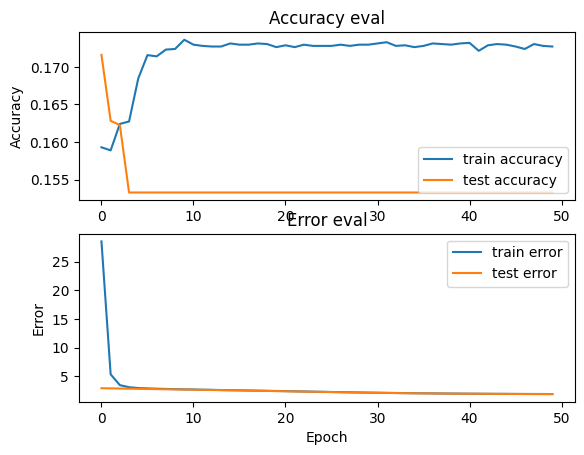

In [25]:
plot_history(history)

# Evaluate the Model

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')
print(f'\nTest loss: {test_loss}')

36/36 - 0s - loss: 2.1757 - accuracy: 0.2084 - 81ms/epoch - 2ms/step

Test accuracy: 0.2084432691335678

Test loss: 2.1757421493530273


# Make Predictions

In [ ]:
predictions = model.predict(X_test)

36/36 [==============================] - 0s 2ms/step


# Post-Processing and Analysis

# Save and Export Model

In [ ]:
model.save('audio_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
